Using device: cuda
Training Normal Autoencoder...
Epoch 1/10, Batch 0, Loss: 0.230924
Epoch 1/10, Batch 200, Loss: 0.046301
Epoch 1/10, Batch 400, Loss: 0.029860
Epoch 1/10, Average Loss: 0.046404, LR: 0.001000
Epoch 2/10, Batch 0, Loss: 0.027086
Epoch 2/10, Batch 200, Loss: 0.023128
Epoch 2/10, Batch 400, Loss: 0.021565
Epoch 2/10, Average Loss: 0.023359, LR: 0.001000
Epoch 3/10, Batch 0, Loss: 0.020498
Epoch 3/10, Batch 200, Loss: 0.018250
Epoch 3/10, Batch 400, Loss: 0.016942
Epoch 3/10, Average Loss: 0.017997, LR: 0.001000
Epoch 4/10, Batch 0, Loss: 0.015100
Epoch 4/10, Batch 200, Loss: 0.014452
Epoch 4/10, Batch 400, Loss: 0.013709
Epoch 4/10, Average Loss: 0.014945, LR: 0.001000
Epoch 5/10, Batch 0, Loss: 0.015363
Epoch 5/10, Batch 200, Loss: 0.013819
Epoch 5/10, Batch 400, Loss: 0.014081
Epoch 5/10, Average Loss: 0.013441, LR: 0.000800
Epoch 6/10, Batch 0, Loss: 0.012110
Epoch 6/10, Batch 200, Loss: 0.013033
Epoch 6/10, Batch 400, Loss: 0.011728
Epoch 6/10, Average Loss: 0.01217

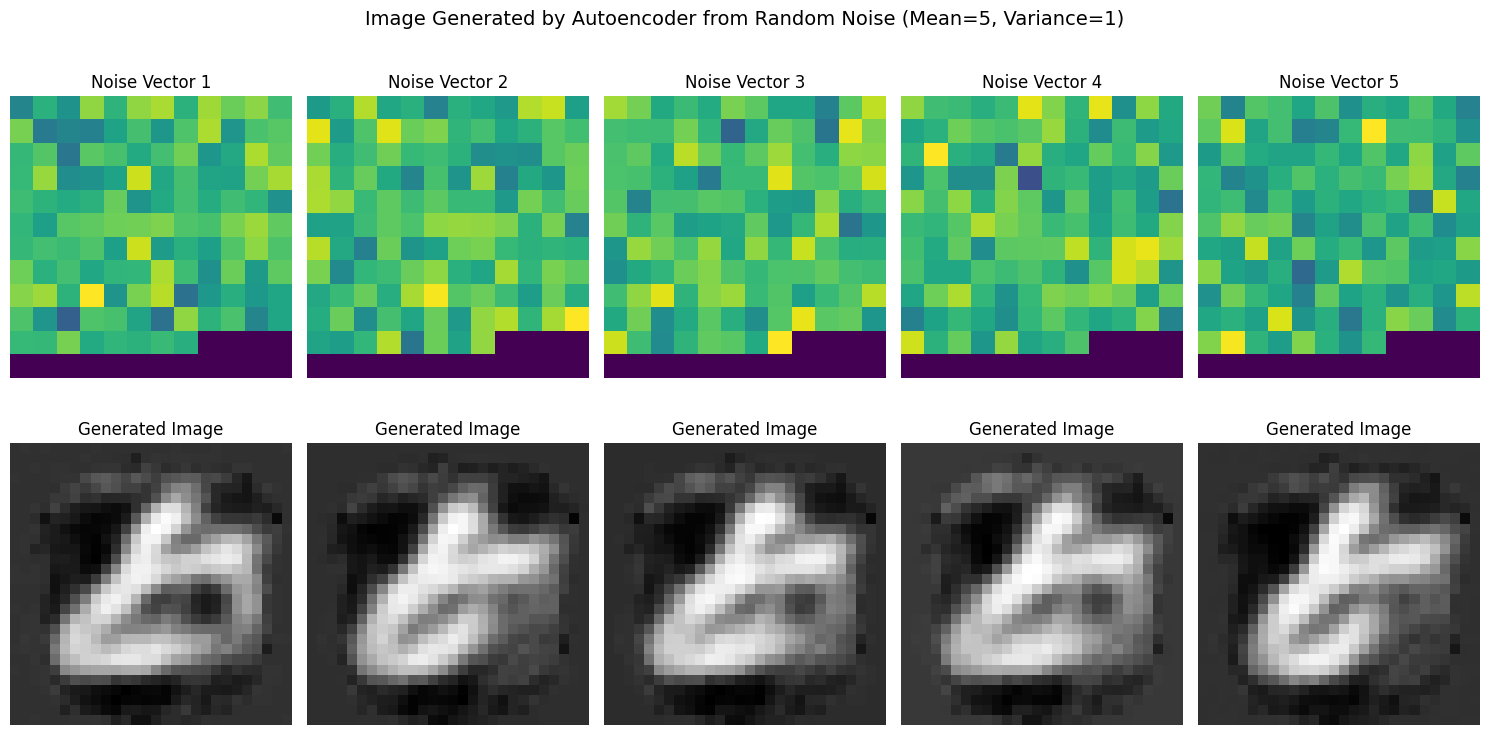

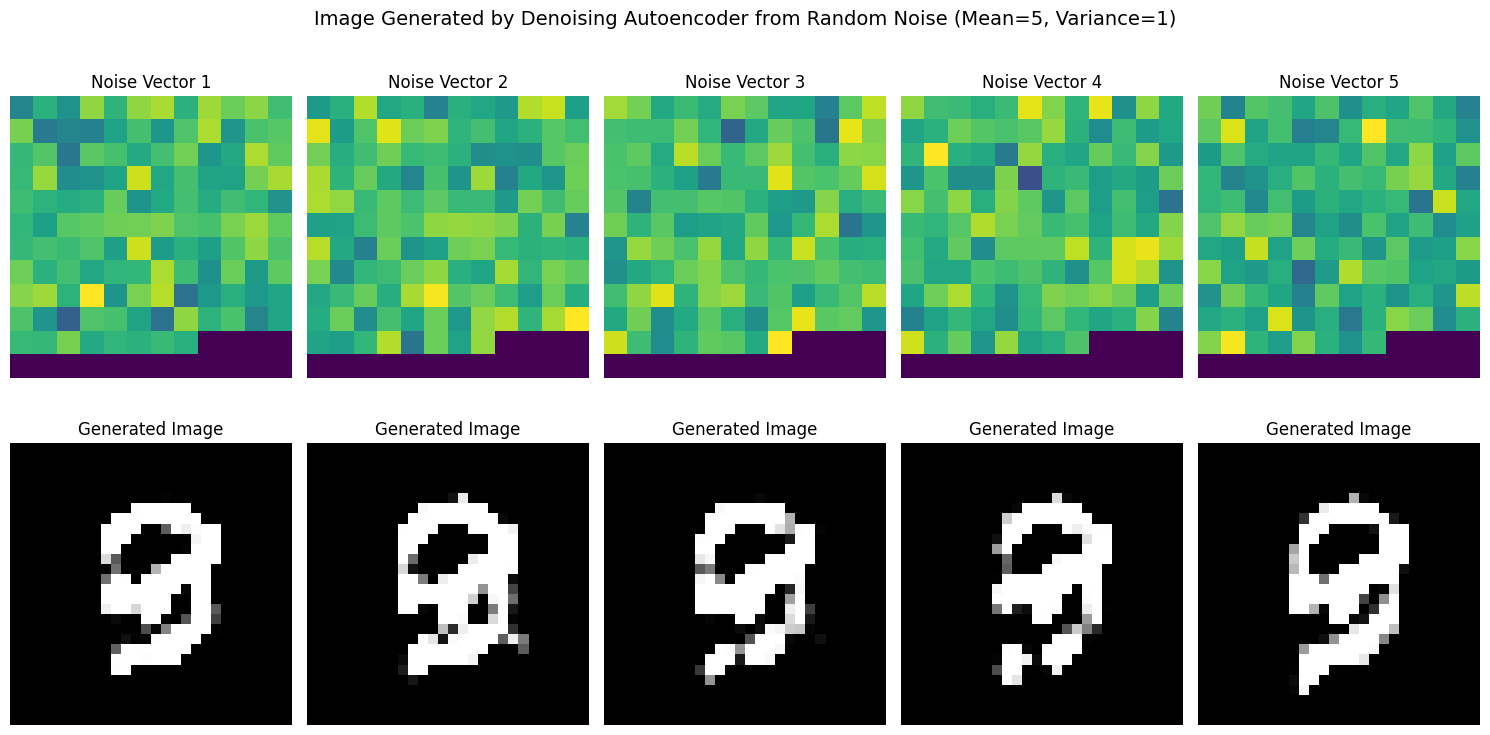

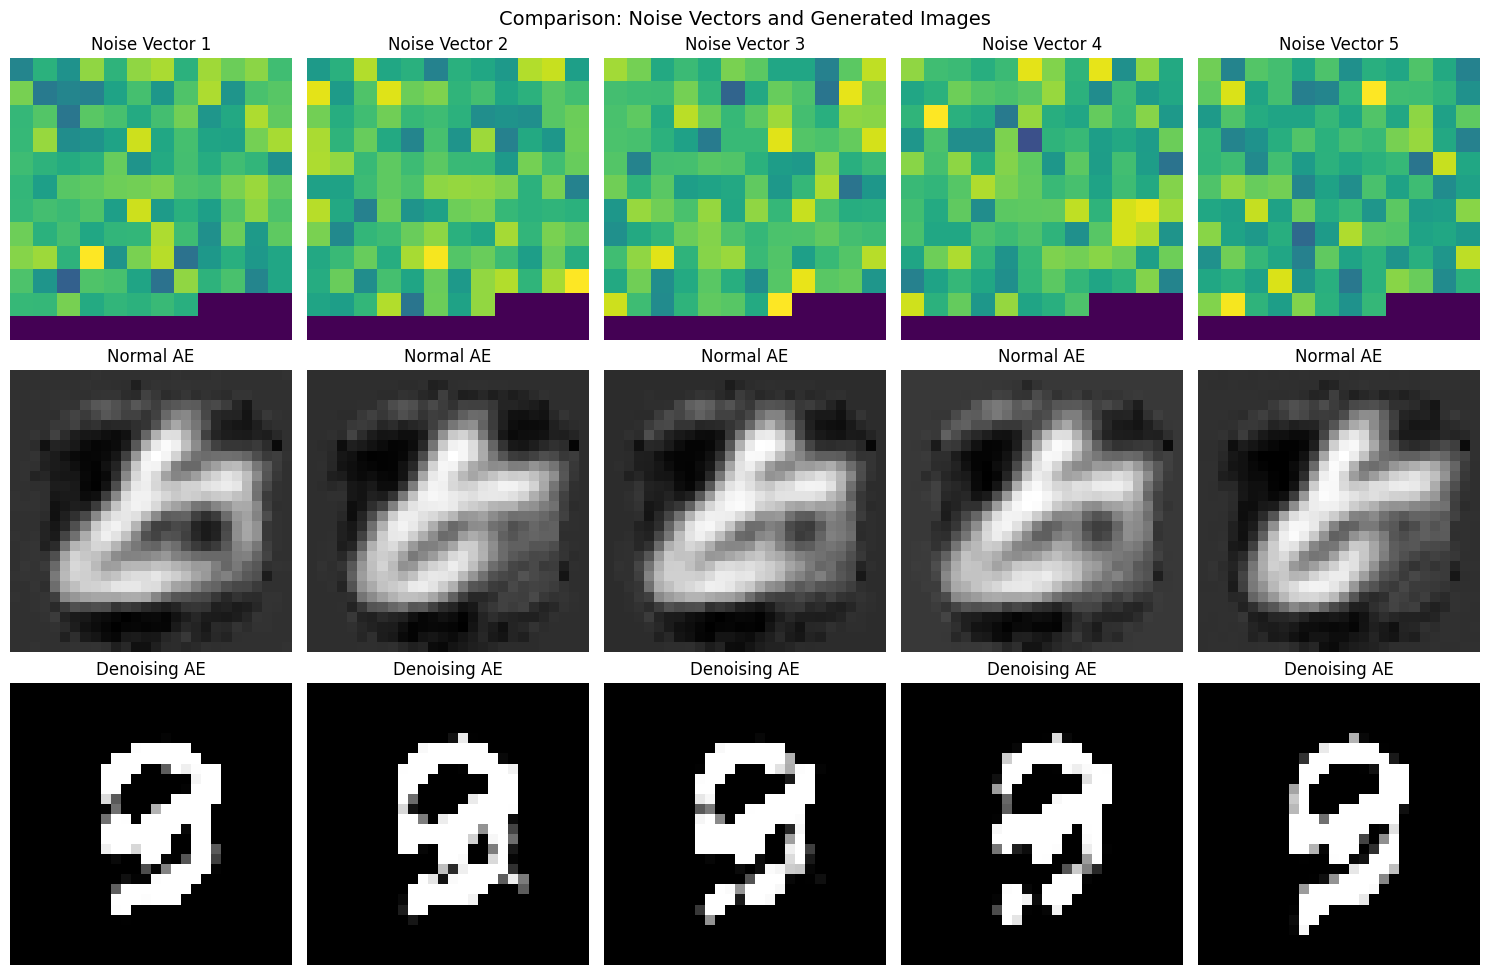


Noise Vector Statistics:
Generated 5 noise vectors with mean=5, variance=1
Actual mean of generated vectors: 5.0489
Actual variance of generated vectors: 0.9437
Shape of each noise vector: (128,)
Visualized as 12x12 2D grids

Performing detailed noise vector analysis...


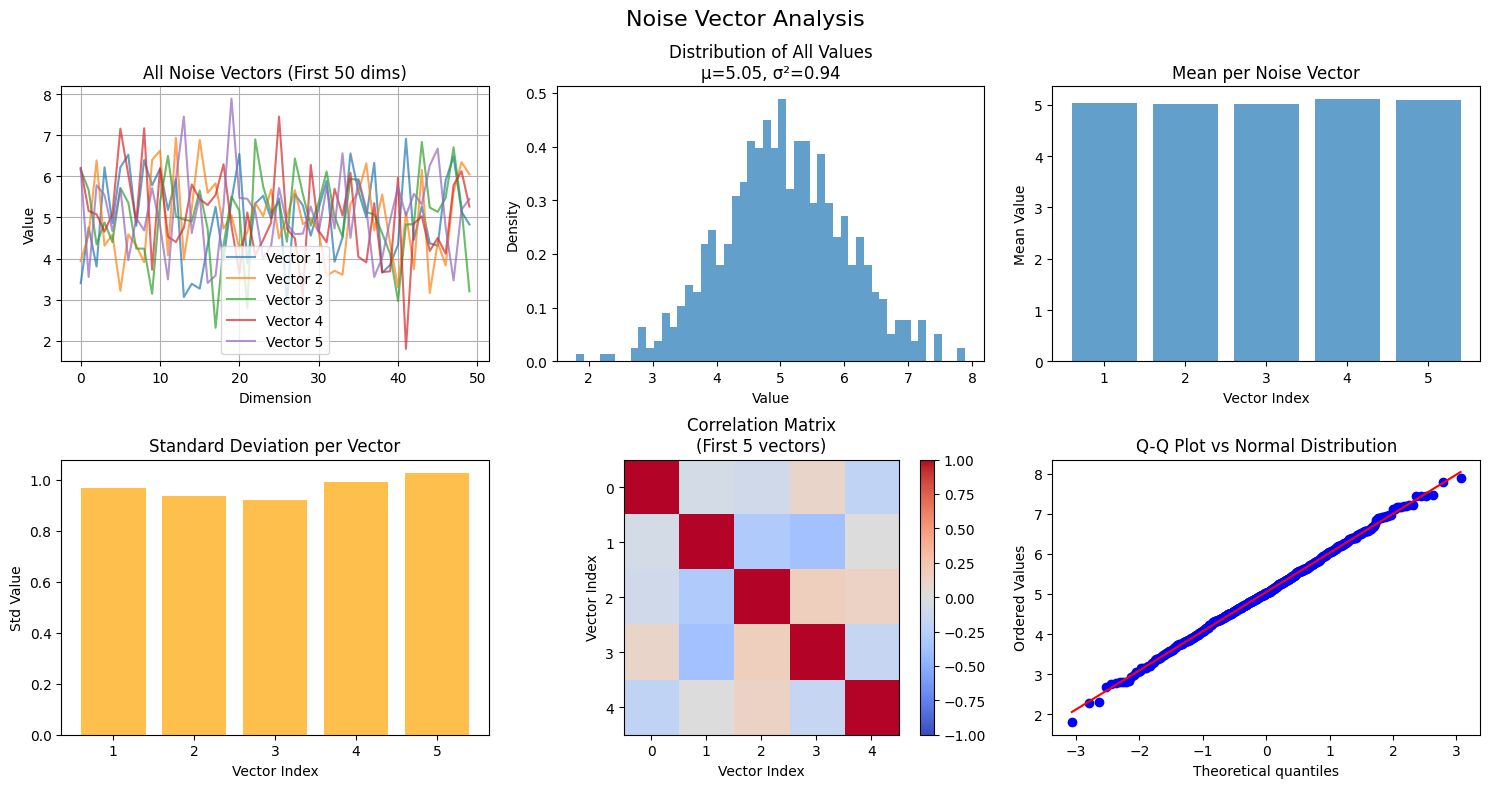


Generation complete! The plots show:
1. Histograms and line plots of the noise vectors
2. Generated images from both Normal and Denoising Autoencoders
3. Direct comparison between the two autoencoder outputs
4. Detailed statistical analysis of the noise vectors


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define Normal Autoencoder
class NormalAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(NormalAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

# Define Denoising Autoencoder (improved architecture)
class DenoisingAutoencoder(nn.Module):
    def __init__(self, latent_dim=128, noise_factor=0.2):
        super(DenoisingAutoencoder, self).__init__()
        self.noise_factor = noise_factor
        
        # Encoder (improved with dropout and batch norm)
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, latent_dim)
        )
        
        # Decoder (improved with dropout and batch norm)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )
    
    def add_noise(self, x):
        noise = torch.randn_like(x) * self.noise_factor
        return torch.clamp(x + noise, 0., 1.)
    
    def forward(self, x):
        # Add noise during training
        if self.training:
            noisy_x = self.add_noise(x)
        else:
            noisy_x = x
        encoded = self.encoder(noisy_x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

# Load and preprocess MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Training function (improved for better results)
def train_autoencoder(model, train_loader, epochs=15):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(data.size(0), -1).to(device)
            
            # Normalize data to [0, 1]
            data = (data + 1) / 2
            
            optimizer.zero_grad()
            
            if isinstance(model, DenoisingAutoencoder):
                # For denoising autoencoder, loss is between clean and reconstructed
                reconstructed = model(data)
                loss = criterion(reconstructed, data)
            else:
                # For normal autoencoder
                reconstructed = model(data)
                loss = criterion(reconstructed, data)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            if batch_idx % 200 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.6f}')
        
        scheduler.step()
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {total_loss/len(train_loader):.6f}, LR: {scheduler.get_last_lr()[0]:.6f}')

# Initialize models
latent_dim = 128
normal_ae = NormalAutoencoder(latent_dim).to(device)
denoising_ae = DenoisingAutoencoder(latent_dim).to(device)

# Train both models (you can skip this if you have pre-trained models)
print("Training Normal Autoencoder...")
train_autoencoder(normal_ae, train_loader, epochs=10)

print("\nTraining Denoising Autoencoder...")
train_autoencoder(denoising_ae, train_loader, epochs=15)

# Generate noise vectors from normal distribution with mean=5, variance=1
def generate_noise_vectors(num_vectors=5, latent_dim=128, mean=5, variance=1):
    """Generate noise vectors from normal distribution"""
    std = np.sqrt(variance)
    noise_vectors = torch.normal(mean=mean, std=std, size=(num_vectors, latent_dim))
    return noise_vectors

# Generate images using both autoencoders
def generate_and_plot_images(normal_model, denoising_model, num_images=5, mean=5, variance=1):
    """Generate images from noise vectors and plot results"""
    
    # Generate noise vectors
    noise_vectors = generate_noise_vectors(num_images, latent_dim, mean, variance)
    noise_vectors = noise_vectors.to(device)
    
    # Set models to evaluation mode
    normal_model.eval()
    denoising_model.eval()
    
    with torch.no_grad():
        # Generate images using normal autoencoder
        normal_generated = normal_model.decode(noise_vectors)
        normal_generated = normal_generated.cpu().numpy().reshape(num_images, 28, 28)
        
        # Generate images using denoising autoencoder
        denoising_generated = denoising_model.decode(noise_vectors)
        denoising_generated = denoising_generated.cpu().numpy().reshape(num_images, 28, 28)
    
    # Convert noise vectors to numpy for plotting
    noise_vectors_np = noise_vectors.cpu().numpy()
    
    # Reshape noise vectors for 2D visualization (similar to your reference image)
    # We'll reshape the latent vector into a 2D grid for visualization
    grid_size = int(np.sqrt(latent_dim))  # For 128D, this would be roughly 11x11
    if grid_size * grid_size < latent_dim:
        grid_size += 1
    
    # Create the main plot like your reference image
    fig, axes = plt.subplots(2, num_images, figsize=(15, 8))
    fig.suptitle(f'Image Generated by Autoencoder from Random Noise (Mean={mean}, Variance={variance})', fontsize=14)
    
    for i in range(num_images):
        # Reshape noise vector to 2D grid for visualization
        noise_2d = np.zeros((grid_size, grid_size))
        noise_flat = noise_vectors_np[i]
        noise_2d.flat[:len(noise_flat)] = noise_flat
        
        # Plot noise vector as 2D heatmap (top row)
        im = axes[0, i].imshow(noise_2d, cmap='viridis', aspect='equal')
        axes[0, i].set_title(f'Noise Vector {i+1}')
        axes[0, i].axis('off')
        
        # Plot generated image (bottom row) - using normal autoencoder
        axes[1, i].imshow(normal_generated[i], cmap='gray')
        axes[1, i].set_title(f'Generated Image')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Create separate plot for denoising autoencoder results
    fig2, axes2 = plt.subplots(2, num_images, figsize=(15, 8))
    fig2.suptitle(f'Image Generated by Denoising Autoencoder from Random Noise (Mean={mean}, Variance={variance})', fontsize=14)
    
    for i in range(num_images):
        # Reshape noise vector to 2D grid for visualization
        noise_2d = np.zeros((grid_size, grid_size))
        noise_flat = noise_vectors_np[i]
        noise_2d.flat[:len(noise_flat)] = noise_flat
        
        # Plot noise vector as 2D heatmap (top row)
        im = axes2[0, i].imshow(noise_2d, cmap='viridis', aspect='equal')
        axes2[0, i].set_title(f'Noise Vector {i+1}')
        axes2[0, i].axis('off')
        
        # Plot generated image using denoising autoencoder (bottom row)
        axes2[1, i].imshow(denoising_generated[i], cmap='gray')
        axes2[1, i].set_title(f'Generated Image')
        axes2[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Create direct comparison plot
    fig3, axes3 = plt.subplots(3, num_images, figsize=(15, 10))
    fig3.suptitle('Comparison: Noise Vectors and Generated Images', fontsize=14)
    
    for i in range(num_images):
        # Reshape noise vector to 2D grid for visualization
        noise_2d = np.zeros((grid_size, grid_size))
        noise_flat = noise_vectors_np[i]
        noise_2d.flat[:len(noise_flat)] = noise_flat
        
        # Plot noise vector (top row)
        axes3[0, i].imshow(noise_2d, cmap='viridis', aspect='equal')
        axes3[0, i].set_title(f'Noise Vector {i+1}')
        axes3[0, i].axis('off')
        
        # Plot normal autoencoder result (middle row)
        axes3[1, i].imshow(normal_generated[i], cmap='gray')
        axes3[1, i].set_title(f'Normal AE')
        axes3[1, i].axis('off')
        
        # Plot denoising autoencoder result (bottom row)
        axes3[2, i].imshow(denoising_generated[i], cmap='gray')
        axes3[2, i].set_title(f'Denoising AE')
        axes3[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nNoise Vector Statistics:")
    print(f"Generated {num_images} noise vectors with mean={mean}, variance={variance}")
    print(f"Actual mean of generated vectors: {noise_vectors_np.mean():.4f}")
    print(f"Actual variance of generated vectors: {noise_vectors_np.var():.4f}")
    print(f"Shape of each noise vector: {noise_vectors_np.shape[1:]}")
    print(f"Visualized as {grid_size}x{grid_size} 2D grids")
    
    return normal_generated, denoising_generated, noise_vectors_np

# Generate and plot results
print("\nGenerating images from noise vectors...")
normal_images, denoising_images, noise_vecs = generate_and_plot_images(
    normal_ae, denoising_ae, num_images=5, mean=5, variance=1
)

# Additional analysis plot
def plot_noise_vector_analysis(noise_vectors, num_vectors=5):
    """Create detailed analysis of noise vectors"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle('Noise Vector Analysis', fontsize=16)
    
    # Plot 1: All noise vectors overlaid
    axes[0, 0].set_title('All Noise Vectors (First 50 dims)')
    for i in range(num_vectors):
        axes[0, 0].plot(noise_vectors[i][:50], alpha=0.7, label=f'Vector {i+1}')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Dimension')
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].grid(True)
    
    # Plot 2: Distribution of all values
    all_values = noise_vectors.flatten()
    axes[0, 1].hist(all_values, bins=50, alpha=0.7, density=True)
    axes[0, 1].set_title(f'Distribution of All Values\nμ={all_values.mean():.2f}, σ²={all_values.var():.2f}')
    axes[0, 1].set_xlabel('Value')
    axes[0, 1].set_ylabel('Density')
    
    # Plot 3: Mean and std per vector
    means = [vec.mean() for vec in noise_vectors]
    stds = [vec.std() for vec in noise_vectors]
    x = range(1, num_vectors + 1)
    axes[0, 2].bar(x, means, alpha=0.7, label='Mean')
    axes[0, 2].set_title('Mean per Noise Vector')
    axes[0, 2].set_xlabel('Vector Index')
    axes[0, 2].set_ylabel('Mean Value')
    
    # Plot 4: Standard deviation per vector
    axes[1, 0].bar(x, stds, alpha=0.7, color='orange', label='Std')
    axes[1, 0].set_title('Standard Deviation per Vector')
    axes[1, 0].set_xlabel('Vector Index')
    axes[1, 0].set_ylabel('Std Value')
    
    # Plot 5: Correlation matrix (first 5 vectors, first 20 dims)
    if noise_vectors.shape[0] >= 2 and noise_vectors.shape[1] >= 20:
        subset = noise_vectors[:min(5, num_vectors), :20]
        corr_matrix = np.corrcoef(subset)
        im = axes[1, 1].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 1].set_title('Correlation Matrix\n(First 5 vectors)')
        axes[1, 1].set_xlabel('Vector Index')
        axes[1, 1].set_ylabel('Vector Index')
        plt.colorbar(im, ax=axes[1, 1])
    
    # Plot 6: Q-Q plot against normal distribution
    from scipy import stats
    stats.probplot(all_values, dist="norm", plot=axes[1, 2])
    axes[1, 2].set_title('Q-Q Plot vs Normal Distribution')
    
    plt.tight_layout()
    plt.show()

# Run additional analysis
print("\nPerforming detailed noise vector analysis...")
plot_noise_vector_analysis(noise_vecs, num_vectors=5)

print("\nGeneration complete! The plots show:")
print("1. Histograms and line plots of the noise vectors")
print("2. Generated images from both Normal and Denoising Autoencoders")
print("3. Direct comparison between the two autoencoder outputs")
print("4. Detailed statistical analysis of the noise vectors")